# Цель проекта:
    Разработать решение, которое позволит персонализировать предложения постоянным клиентам интернет-магазина «В один клик», чтобы увеличить их покупательскую активность.
        1. Первым шагом будет изучение данных, их предобработка, и анализ, с целью выявления зависимостей, а так же оценки этих зависимостей. Сбор данных по требуемым заказчиком группам, для оценки их покупательской способности
        2. Вторым шагом будет построение моделий ML, и выбор самых оптимальных параметров для этих моделей, сравнение различный моделей ML, оценка их качества и способности к предсказаниям.
        3. Выбор оптимальных моделий для различных критериев отбора клиентов. Использование моделей для прогнозирования.
        4.Вывод на основе полученных данных и рекомендации интернет магазину.

## Загрузка и иследование данных.

### Импортируем библиотеки, и функции для работы с моделями, загрузим данные, проведем первичный анализ данных

In [1]:
!pip install phik -q
!pip install shap  -q 
!pip install matplotlib==3.5.0 -q 
!pip install scikit-learn==1.1.3 -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import numpy as np
import phik
import shap
import statsmodels.api as sm


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import ( StandardScaler, 
                                  OneHotEncoder, 
                                  OrdinalEncoder,
                                  MinMaxScaler )

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import GridSearchCV


from sklearn.inspection import permutation_importance

### Сразу установим константы.

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

### Загрузим и посмотрим на данные.

In [4]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=",")

In [5]:
def data_info(data):
    print(data.head())
    print('________________________________')
    data.info()
    print('________________________________')
    print(data.describe().T)
    print('________________________________')
    print('Кол-во пропусков:\n', data.isna().sum())
    print('________________________________')
    print('Кол-во явных дубликатов:', data.duplicated().sum())
    print('________________________________')

In [6]:
data_info(market_file)

       id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей             

Пропусков и дупликатов нет. В названиях колонок есть пробелы, потом устраним.

In [7]:
data_info(market_money)

       id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6
________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
________________________________
          count           mean          std       min        25%       50%  \
id       3900.0  215997.500000   375.325686  215348.0  215672.75  215997.5   
Выручка  3900.0    5025.696051  1777.704104       0.0    4590.15    4957.5   

               75%       max  
id       216322.25  216647.0  
Выручка    5363.00  106862.2  
_______

Пропусков и дупликатов нет. По первым 5 клиентам видно, что покупки соверщаются не ежемесячно, в прошлом месяце есть клиенты которые ничего не купили. В колонке выручка min значение 0 как раз по этой причине.

In [8]:
data_info(market_time)

       id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13
________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
________________________________
        count           mean         std       min        25%       50%  \
id     2600.0  215997.500000  375.349754  215348.0  215672.75  215997.5   
минут  2600.0      13.336154    4.080198       4.0      10.00      13.0   

             75%       max  
id     216322.25  216647.0  
минут      16.00      23.0  
________________________________
Кол-во пропусков:
 id        0
Период    

В 3 датасете пропусков и дупликатов нет. Среднее время на сайте 13 минут, минимальное 4, максимальное 23.

In [9]:
data_info(money)

       id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21
________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
________________________________
          count           mean         std        min        25%         50%  \
id       1300.0  215997.500000  375.421985  215348.00  215672.75  215997.500   
Прибыль  1300.0       3.996631    1.013722       0.86       3.30       4.045   

               75%        max  
id       216322.25  216647.00  
Прибыль       4.67       7.43  
________________________________
Кол-во пропусков:
 id         0
Прибыль    0
dtype: int64
________________________________
Кол-во явных дубликатов: 0
_______________________

В 4 датасете пропусков и дупликатов нет. Пока не понятно в каких единицах измерения отражается прибыль с клиента. Средняя прибыль с клиента 4 у.е.

### Вывод по загрузке и исследованию данных:
    1. Загрузил библиотеки, а так же модели, функции, и метрики.
    2. В данных не обнаруженные явные дупликаты, а так же пропуски.
    3. В первом датасете есть пробелы в названиях колонок.
    

## Предобработка данных 

### Уберем пробелы в первом датасете, и привидем названия колонок к нижнему регистру

In [10]:
market_file.columns = market_file.columns.str.replace(' ', '_').str.lower()
market_money.columns = market_money.columns.str.replace(' ', '_').str.lower()
market_time.columns = market_time.columns.str.replace(' ', '_').str.lower()
money.columns = money.columns.str.replace(' ', '_').str.lower()

In [11]:
market_file.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

### Вывод по предобработке данных:
Исправили названия колонок в данных, и привели все к нижнему регистру.

## Исследовательский анализ данных

In [12]:
def pivot_pie_chart(df, col): # Строит пирог с долями, по признаку.
    plt.figure(figsize=(8,8))
    plt.pie(df[col].value_counts(), labels=df[col].value_counts().index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Распределение по {col}', fontsize=16)
    plt.show()
    
def hist_with_wiskers(df, col, target): # строит два вида гистограмм, один для сравнения с целевым признаком, второй для оценки распределения. Так же строит ящик с усами
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(f'Распределение признака  {col}', fontsize=16)
    axes[0].set_ylabel('Количество', fontsize=14)
    if target != None:
        sns.histplot(df, bins=20, kde=True, ax=axes[0], hue=target, x=col)
    else:
        sns.histplot(df, bins=20, kde=True, ax=axes[0], x=col)
    axes[1].set_title(f'График ящик с усами для признака {col}', fontsize=16)
    sns.boxplot(data=df, ax=axes[1], y=col)
    axes[1].set_ylabel(col, fontsize=14)
    plt.show() 
    
def histogram(df, col, target): # Строит гистограмму по признаку.
    plt.figure(figsize=(8,6))
    plot = sns.histplot(df, bins=20, kde=True, hue=target, x=col)
    plot.set_title(f'Рапределение по {col}', fontsize=16)
    plot.set_ylabel('Количество', fontsize=14)

### Построим круговые диаграммы и гистограммы для первого набора данных.

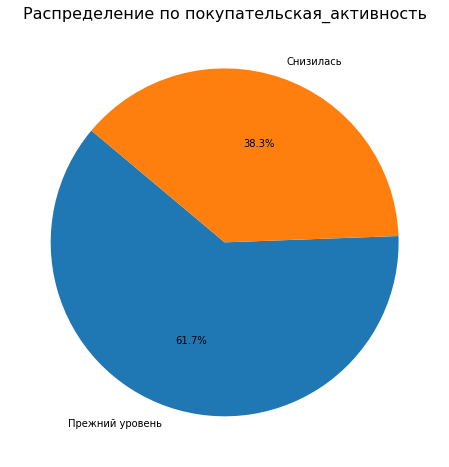

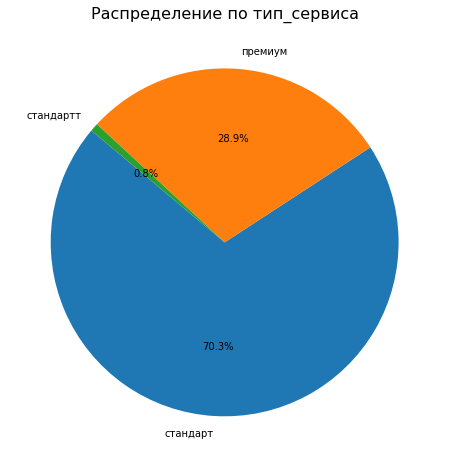

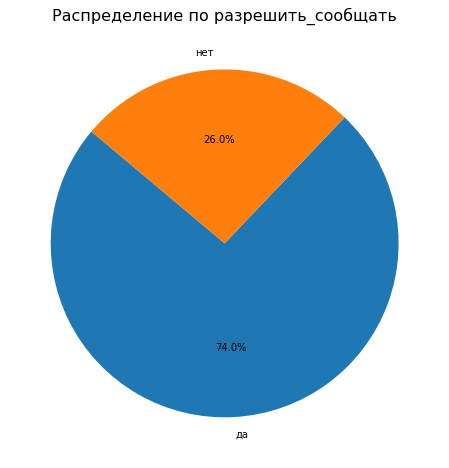

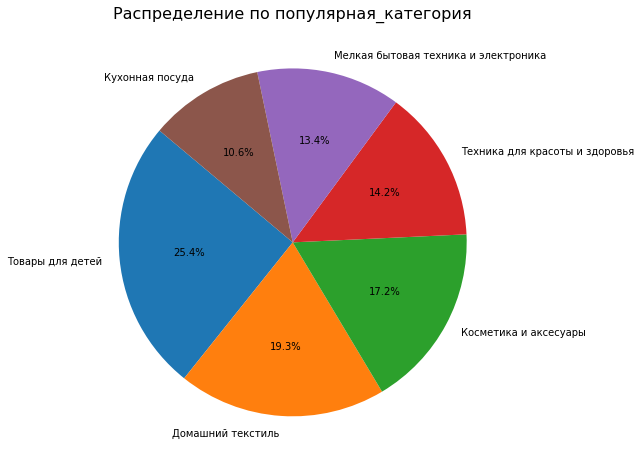

In [13]:
a = ['покупательская_активность','тип_сервиса','разрешить_сообщать',
     'популярная_категория']
for i in a:
    pivot_pie_chart(market_file,i)



По первой диаграмме видно, что у 38.3% клиентов снизилась покупательская активность.\
По второй диаграмме мы видим опечатку в данных, а так же что премиум пользователей всего 28.9% от общего числа, опечатку исправим для работы с данными.\
В третей диаграмме мы видим что 74% пользователей согласны на рекламные рассылки.\
В четвертой диаграмме видим, что на товары для детей приходится четверть всех покупок на сервисе, далее идет домашний текстиль и косметика.

In [14]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт','стандарт')

Пострим гистограммы для оценки активности пользователей.

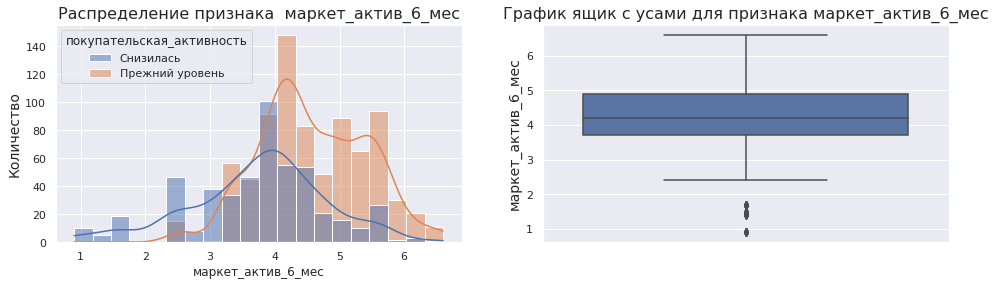

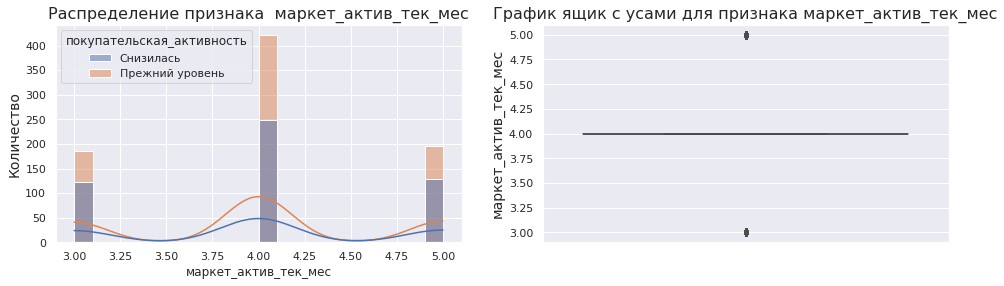

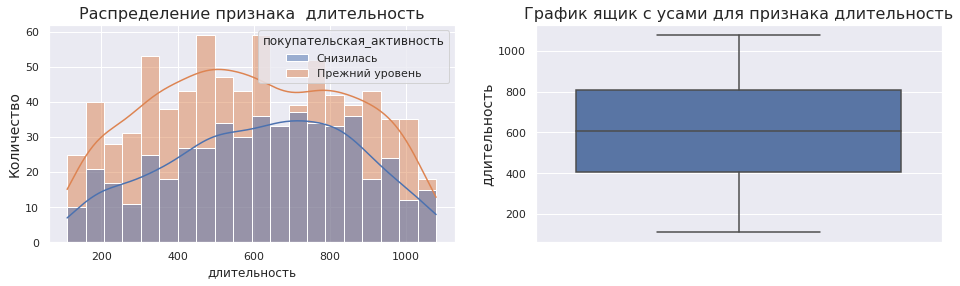

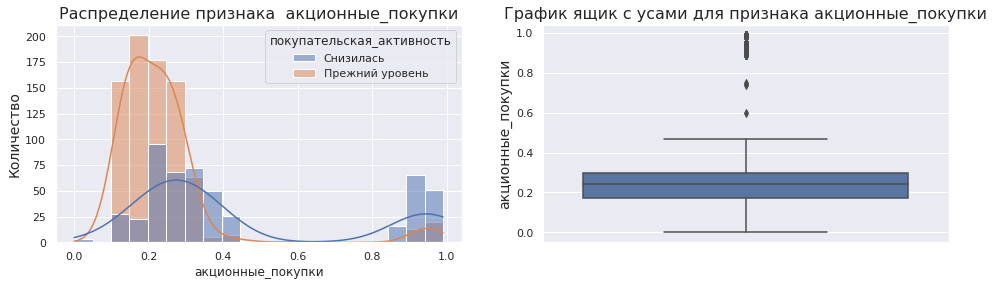

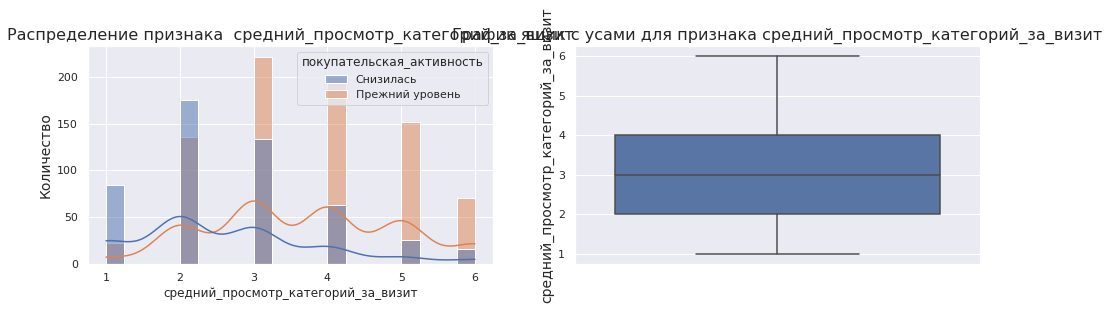

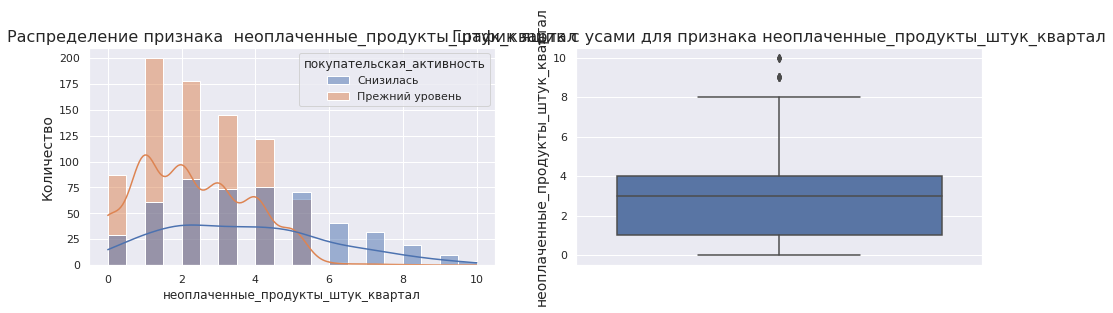

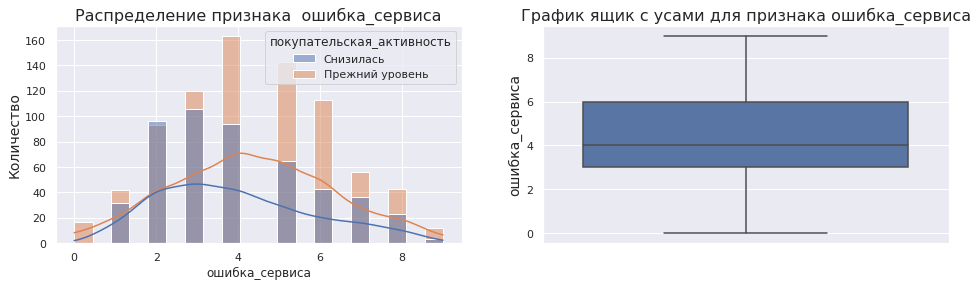

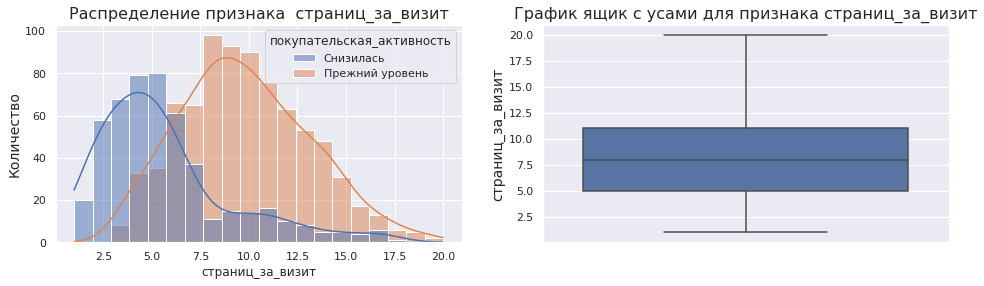

In [15]:
a = ['маркет_актив_6_мес','маркет_актив_тек_мес','длительность','акционные_покупки',
     'средний_просмотр_категорий_за_визит','неоплаченные_продукты_штук_квартал','ошибка_сервиса','страниц_за_визит']
for i in a:
    hist_with_wiskers(market_file, i, 'покупательская_активность')


#### Вывод по первому набору данных:
    По первому признаку 'маркет_актив_6_мес' мы видим нормальное распределение, есть несколько выбрососов при значении меньше 2, убирать или нет пока не понятно.

    По второму признаку 'маркет_актив_тек_мес' мы видим четкое распределение на 3 категории, сделаем этот признак категореальным.

    По третьему признаку 'длительность', мы видим нормально распределение. Выбросов для коректировки нет.

    По четвертому признаку 'акционные_покупки' мы видим что есть две категории покупателей, первая которым не важны скидки, и тем кто покупает только по скидкам, можно разделить данные на две категории, и сделать признак категореальным.

    По пятому признаку 'средний_просмотр_категорий_за_визит' мы видим нормальное распределение, видим 6 столбцов, можно сделать признак категореальным, с 6 категориями.

    По шестому признаку 'неоплаченные_продукты_штук_квартал' мы видим что присутсувую большие значение у тех, у кого снизилась покупательская активность, а так же видим, что те кто до сих пор пользуются сервисом, не хранят более 5 товаров в корзине, можем сделать признак категореальным с 9 категориями, отбросив значения выше 8 предметов в корзине.

    По седьмому признаку 'ошибка_сервиса' видим нормальное распределение, выбросов нет.

    По восьмому признаку 'страниц_за_визит' видно, что у тех у кого снизилась покупательская активность, просматривают меньше страниц, выбросов нет.

### Построим диаграммы и гистограммы для второго набора данных

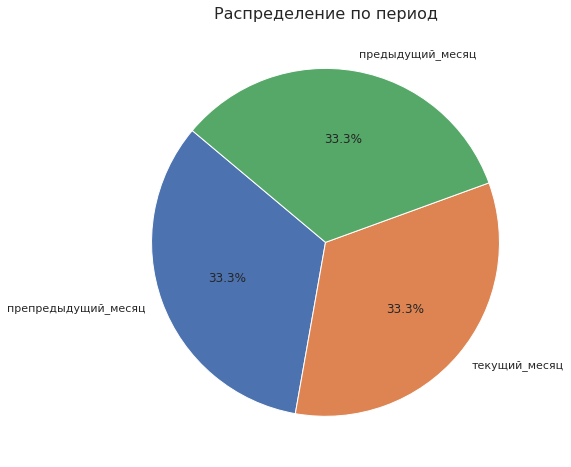

In [16]:
pivot_pie_chart(market_money,'период')

In [17]:
market_money_period_revenue = market_money.pivot_table(index='период',values='выручка',aggfunc='sum')
market_money_period_revenue

,выручка
период,
предыдущий_месяц,6417996.5
препредыдущий_месяц,6272769.0
текущий_месяц,6909449.1


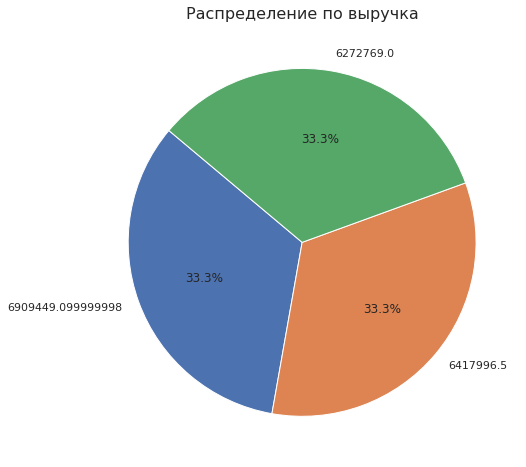

In [18]:
pivot_pie_chart(market_money_period_revenue,'выручка')

Как видно по диаграммам, выручка распределенна нормально по всем исследуемым периодам, так что все периодны в данных в равной пропорции. Построим гистограмму распределения выручки 

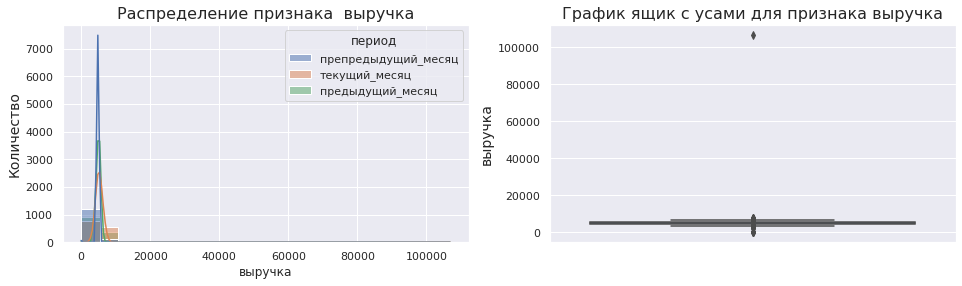

In [19]:
hist_with_wiskers(market_money, 'выручка', 'период')

По гистограмме видим выброс со значением выше 100000, уберем его, так же можем заметить значения, где выручка составил 0 рублей за исследуемые периоды, уберем и их.

In [20]:
market_money = market_money.query("выручка < 100000 & выручка > 0")

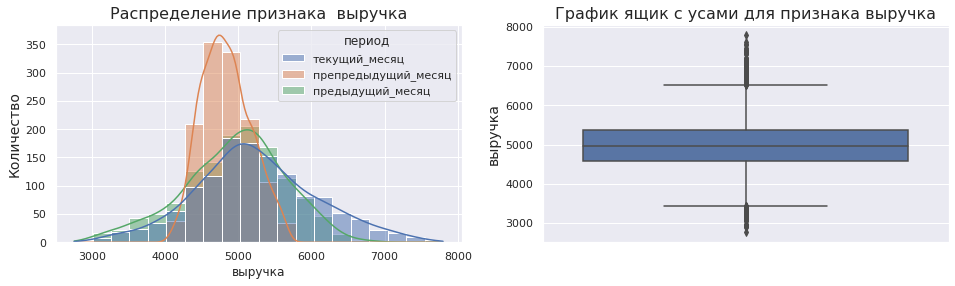

In [21]:
hist_with_wiskers(market_money, 'выручка', 'период')

Теперь мы видим нормальное распределение с небольшим смещением влево. Мы оставили в данных только пользователей которые соверщали покупки последние 3 месяца, убрали выброс с большим числом выкупа. Что и требуется по условиям задачи.

#### Вывод по второму набору данных:
    1. По круговым диаграмам выручка распределенна нормально по всем исследуемым периодам.
    2. На гистограмме 'выручки' обнаружили выбросы в данных. Устранили их.

### Построим графики и гистограммы для 3 набора данных.

market_time период минут

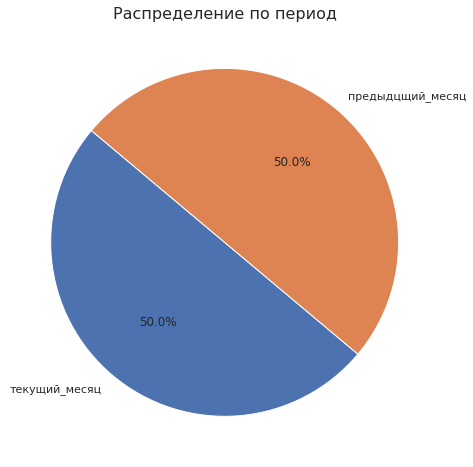

In [22]:
a = ['период']
for i in a:
    pivot_pie_chart(market_time,i)

Как мы видим по первому графику, данные распределенны равномерно по двум периодам. Так же видим опечатку в названнии колонки, исправим ее.

In [23]:
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

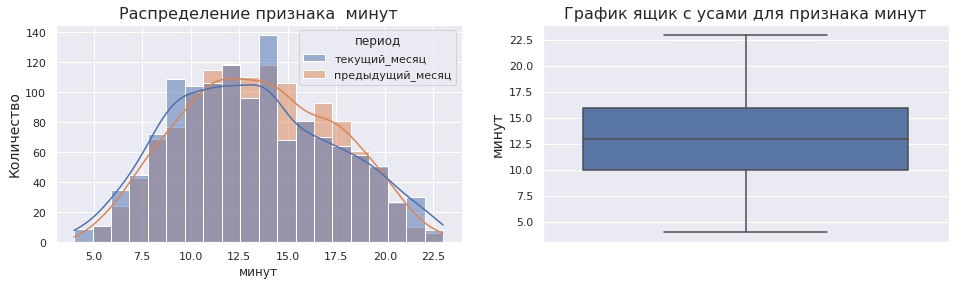

In [24]:
hist_with_wiskers(market_time, 'минут', 'период')

#### Вывод по третьему набору данных:
    1. Периоды в датафреймах распределены одинково 50 на 50%.
    2. По гистограмме видим нормальное распределение, без выбросов.

### Изучим 4 набор данных. Построим гистограммы

money\
id\
прибыль

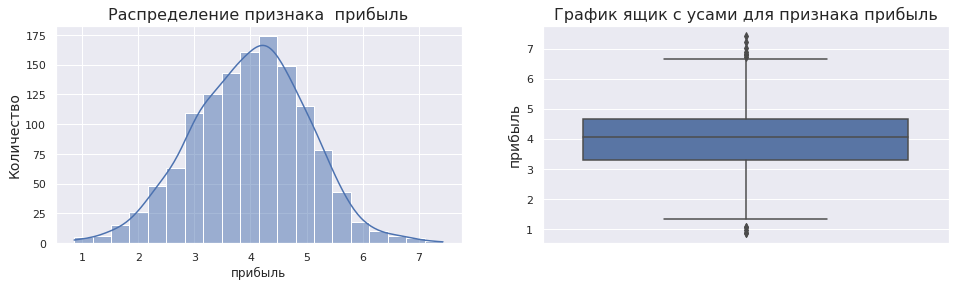

In [25]:
hist_with_wiskers(money, 'прибыль', None)

#### Вывод по четвертому набору данных: 
    1.Как видим по гистограмме прибыль распределена нормально.\

### Необходимо отобрать пользователей с активностью более 3-х месяцев. Сделаем это

In [26]:
d = market_money.pivot_table(index='id', values = 'период',aggfunc='count')

In [27]:
d = d[d['период'] == 3]

In [28]:
market_file = market_file[market_file['id'].isin(d.index)]
len(market_file)

1296

### Вывод по исследовательскому анализу:
    1. Во время анализа были выявленны некоторые опечатки в данных. Скоректировали их.
    2. Данные в целом, распределенны нормально, большие выбросы мы устранили.
    3. Некоторые признаки было решено сделать категориальными, этим займемся далее.
    4. Оставили в датафрейме только тех клиентов которые пользуются сервисом более 3-х месяцев непрерывно.

## Объеденим данные в одну таблицу.

market_file market_money market_time

In [29]:
market_money_group = market_money.pivot_table(index='id', columns='период')
market_money_group.columns = ['выручка_предыдущий_месяц','выручка_препредыдущий_месяц', 'выручка_текущий_месяц']

In [30]:
market_time_group = market_time.pivot_table(index='id', columns='период')
market_time_group.columns = ['продолжительность_мин_предыдущий_месяц', 'продолжительность_мин_текущий_месяц']

In [31]:
market_full = pd.merge(market_file, market_money_group, on ='id',how='inner')
len(market_full)

1296

In [32]:
market_full = pd.merge(market_full, market_time_group, on ='id',how='inner')
len(market_full)

1296

In [33]:
data_info(market_full)

       id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215349                 Снизилась     премиум                 да   
1  215350                 Снизилась    стандарт                нет   
2  215351                 Снизилась    стандарт                 да   
3  215352                 Снизилась    стандарт                нет   
4  215353                 Снизилась    стандарт                 да   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 4.4                     4           819               0.75   
1                 4.9                     3           539               0.14   
2                 3.2                     5           896               0.99   
3                 5.1                     3          1064               0.94   
4                 3.3                     4           762               0.26   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     Товары для детей             

### Вывод по объеденению: 
    1.Объеденил 3 дата фрейма в один.
    2.Дупликатов не появилось.
    3.Кол-во строк осталось как в дата фрейме с отобранными пользователями 1282

## Проведем корреляционный анализ.

In [34]:
def phik_mat(data):
    phik_matrix = data.phik_matrix(verbose=False)
    
    mask = np.triu(np.ones_like(phik_matrix, dtype=bool))
    
    plt.figure(figsize=(20, 15))
    sns.heatmap(phik_matrix, annot=True, fmt='.2f', mask=mask)
    plt.title('Корреляционная матрица (Phik)', fontsize=18)
    plt.show()    

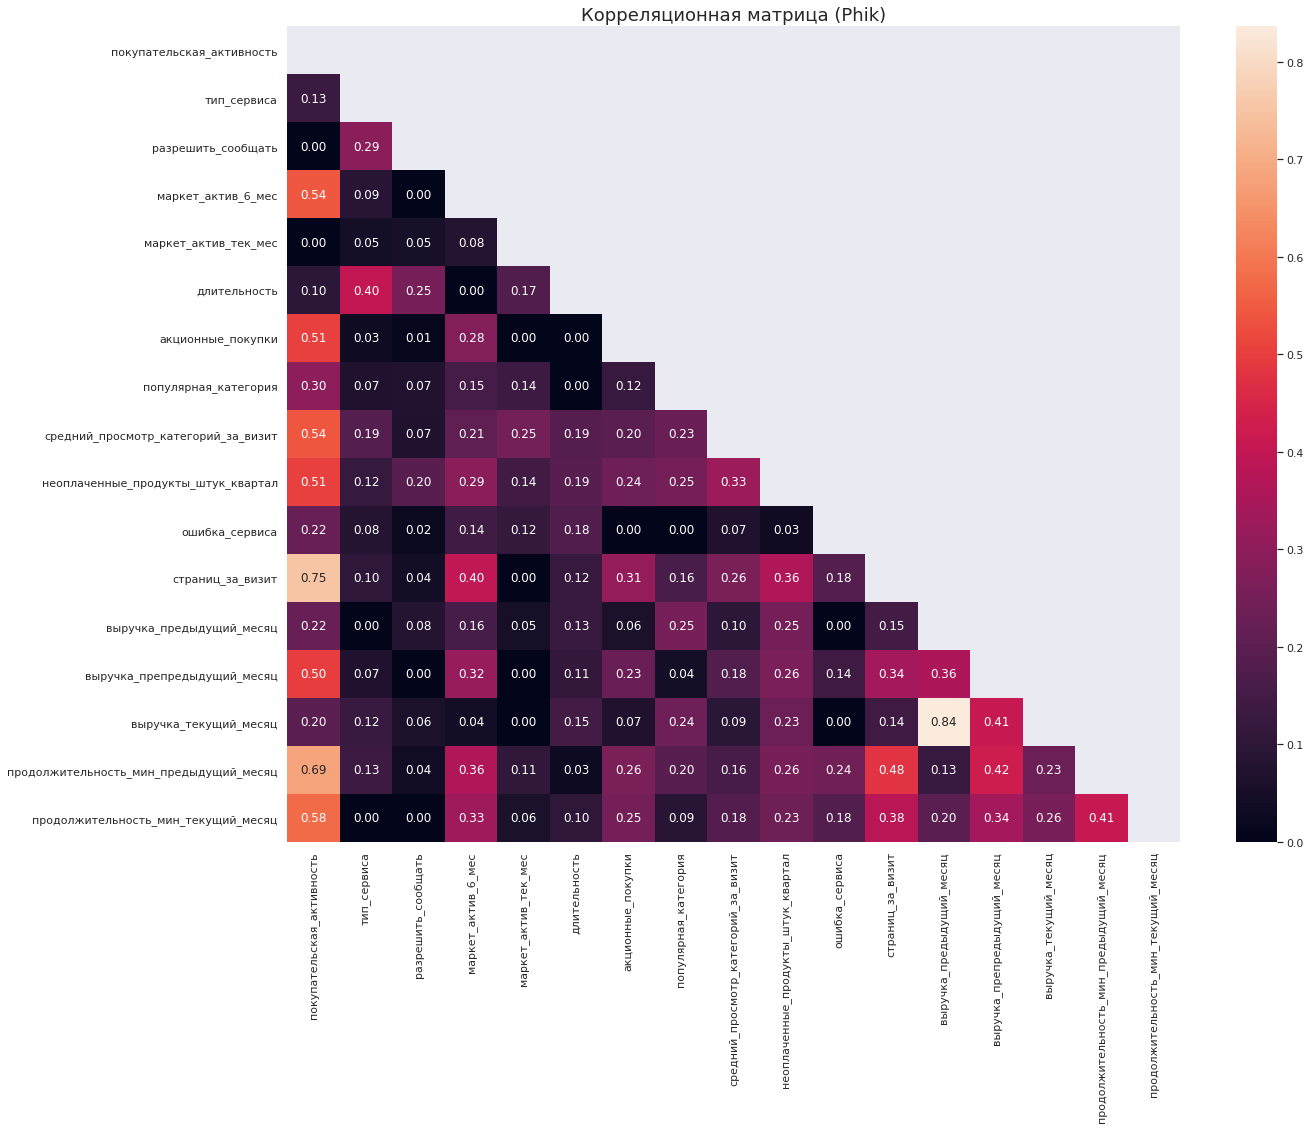

In [35]:
df = market_full.drop('id', axis=1)
phik_mat(df)

### Вывод по кореляционному анализу:
    1. Целевой признак "покупательская активность" хорошо коррелирует с маркет_актив_6_месяцеd, акционные_покупки, средний_просмотр_категорий_за_визит, страниц_за_визит, выручка_препредыдущий_месяц, продолжительность_мин_предыдущий_месяц, продолжительность_мин_текущий_месяц.
    2. Так же мы видим зависимость выручка_текущий_месяц и выручка_предыдущий_месяц.

## Используем пайплайны

In [36]:
market_full = market_full.set_index('id')

In [37]:
market_full['покупательская_активность'] = market_full['покупательская_активность']\
.apply( lambda x: 1 if x=='Снизилась' else 0 )
market_full['покупательская_активность'] = market_full['покупательская_активность'].astype(int) 


market_full['акционные_покупки_категория'] = market_full['акционные_покупки']\
.apply( lambda x: 'Часто покупает по акции' if x>= 0.5 else 'Редко покупает по акции' )
market_full = market_full.drop(['акционные_покупки'], axis=1)

In [38]:
X = market_full.drop(['покупательская_активность'], axis=1)
y = market_full['покупательская_активность']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

In [39]:
ohe_columns = ['тип_сервиса',
               'разрешить_сообщать',
               'популярная_категория'
]

ord_columns = ['акционные_покупки_категория']

num_columns = ['маркет_актив_6_мес',
               'маркет_актив_тек_мес',
               'неоплаченные_продукты_штук_квартал',
               'длительность',
               'неоплаченные_продукты_штук_квартал',
               'ошибка_сервиса',
               'страниц_за_визит',
               'выручка_предыдущий_месяц',
               'выручка_препредыдущий_месяц','выручка_текущий_месяц',
               'продолжительность_мин_предыдущий_месяц',
               'продолжительность_мин_текущий_месяц', 'средний_просмотр_категорий_за_визит'
]

In [40]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='error', sparse=False, drop='first'))
    ]
)

In [41]:
ord_pipe = Pipeline(
    [
        (
            'simple_imputer_ord_before',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(handle_unknown='use_encoded_value',
                          unknown_value=np.nan)
        ),
        (
            'simple_imputer_ord_after',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [42]:
data_preprocessor = ColumnTransformer(
    [('ohe', ord_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [43]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [44]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier(metric='cityblock')],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
                class_weight='balanced',
                random_state=RANDOM_STATE,
                solver='liblinear',
                penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability = True)],
        'models__C': range(1, 4),
        'models__kernel': ['poly','rbf'],
        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough']
    }
   
    
]

In [45]:
grid = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
)

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simple_imputer_ord_before',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=nan)),
                                                                                         ('simple_imputer_ord_after',
                                                                                          SimpleImputer(strategy='most_frequen...
                         {'models': [LogisticRegression(class_weight='balanced',
                                                        penalty='l1',
                                                        random_state=42,
                                                        solver='liblinear')],
                          'models__C': range(1, 5),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [SVC(C=3, probability=True,
                                         random_state=42)],
                          'models__C': range(1, 4),
                          'models__kernel': ['poly', 'rbf'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

Выбрал метрику ROC-AUC так как нам важно правильно отобрать тех пользователей, у которых снизится активность, для точечного стимулирования их к покупкам, с помощью рекламы, рекомендаций, и т.п. При этом нам так же важно правильно отобрать пользователей с прежним уровнем активности, что бы их как можно меньше попало в сегмент, где активность снижается. А так как значение ROC-AUC показывает как хорошо, модель различает категории пользователей, то это оптимальный вариант.

In [46]:
print(f'Best score: {grid.best_score_}, best params: {grid.best_params_}')

Best score: 0.9132512123693941, best params: {'models': SVC(C=3, probability=True, random_state=42), 'models__C': 3, 'models__kernel': 'rbf', 'preprocessor__num': StandardScaler()}


In [47]:
y_test_pred = grid.predict(X_test) 

In [48]:
probabilities = grid.best_estimator_.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой: 0.914694818589977


In [49]:
print(f'Метрика F1-score на тестовой выборке: {f1_score(y_test, y_test_pred, average="binary")}')

Метрика F1-score на тестовой выборке: 0.8711111111111112


### Вывод по выбору лучшей модели и метрики.
    1. При использовании GridSearchCV лучшей моделью стала модель SVC(C=3, kernel='poly', probability=True, random_state=42)
    3. Метрики ROC-AUC и F1-score равны 0.91 и 0.85 соотвественно, F1 не равна 1 что показывает отсутсвие проблемы переобучения, качество модели достаточно высокое. Модель хорошо различает классы целевых объектов.
    

## Анализ важности признаков.

In [50]:
preprocessor = grid.best_estimator_.named_steps['preprocessor']

X_train_processed = preprocessor.transform(X_train)

X_test_processed = preprocessor.transform(X_test)

feature_names = grid.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
X_test_processed = pd.DataFrame(X_test_processed, columns=feature_names)

background_data = shap.sample(X_train_processed, 50)

explainer = shap.KernelExplainer(grid.best_estimator_.named_steps['models'].predict_proba, background_data)



shap_values = explainer(X_test_processed[:100])

  0%|          | 0/100 [00:00<?, ?it/s]

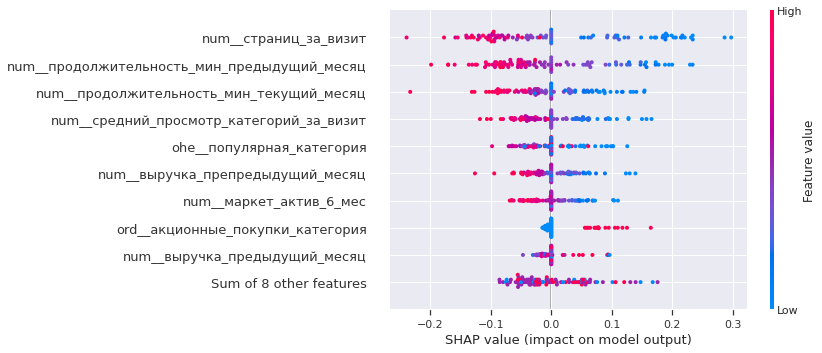

In [51]:
shap.plots.beeswarm(shap_values[..., 1])

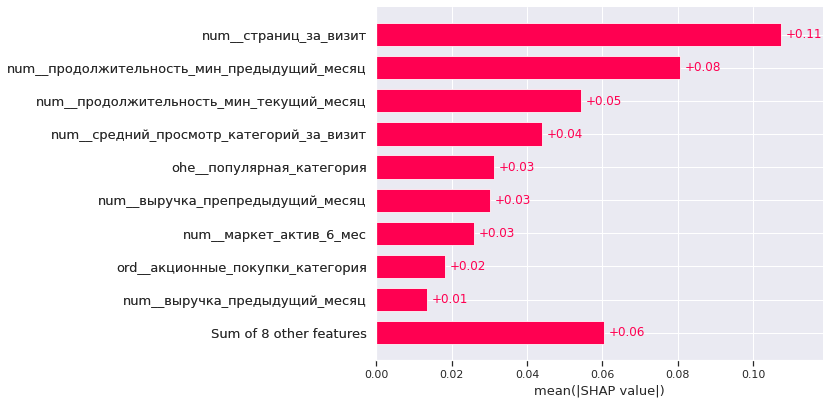

In [52]:
shap.plots.bar(shap_values[..., 1])

### Вывод по анализу важности признаков.
    1. Для модели выжны следующие признаки это: продолжительность минут активности пользователя за предыдущий месяц, страницы просмотренные за визит, средний просмотр категорий за визит, и продолжительность минут активности за этот месяц.
    2. Малозначимыми признаками оказались: Неоплаченные продукты, рекламная активность за 6 последних месяцев, акционные покупки.

    3. По графику beeswarm видно:
        3.1 больше всего влияние на отнесение к какому либо классу целевого признака влияют количественные данные о взаимодействии пользователся с сервисом. Так наприме чем больше пользователь проводил времени на сайте в этом и прошлом месяце, тем больше вероятность, что покупательская активность останется на прежнем уровне. То же самое и с просмотром страниц за визит.
        3.2 При этом чем больше не оплаченных продуктов в корзине, тем больше шанс отнесении к категории целевого признака к снижению активности пользователя.
    



## Сегментация покупателей.

In [53]:
y_test_proba = grid.predict_proba(X_test)[:,1]
y_train_proba = grid.predict_proba(X_train)[:,1]

In [54]:
X_test_full = X_test.copy()
X_train_full = X_train.copy()
X_test_full['вероятность_снижения'] = y_test_proba
X_train_full['вероятность_снижения'] = y_train_proba
df_full = pd.concat([X_train_full, X_test_full])

#Поправил 
money = money.set_index('id')
df_full = pd.merge(df_full, money, on ='id',how='inner')

In [55]:
df_full

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,продолжительность_мин_предыдущий_месяц,продолжительность_мин_текущий_месяц,акционные_покупки_категория,вероятность_снижения,прибыль
id,,,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5,4,510,Мелкая бытовая техника и электроника,2,4,7,16,5170.5,4347.0,6014.2,20,6,Редко покупает по акции,0.051953,4.37
215361,стандарт,да,5.1,4,199,Техника для красоты и здоровья,4,5,2,3,6400.0,4597.0,3789.7,11,13,Редко покупает по акции,0.908854,4.03
215884,стандарт,да,4.3,5,997,Мелкая бытовая техника и электроника,5,1,3,11,4113.0,4626.0,3798.4,13,10,Редко покупает по акции,0.095121,4.37
216564,стандарт,да,5.6,4,342,Кухонная посуда,2,7,5,8,4930.0,5269.0,4766.2,14,19,Часто покупает по акции,0.710249,5.58
215715,премиум,да,3.6,5,873,Товары для детей,3,2,2,5,3716.0,4691.0,4600.0,10,10,Редко покупает по акции,0.936963,4.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215429,премиум,нет,0.9,4,690,Домашний текстиль,2,5,7,4,3662.0,4488.0,4158.6,11,10,Редко покупает по акции,0.941527,3.71
216233,премиум,да,3.9,4,1048,Техника для красоты и здоровья,3,0,6,14,4325.0,4553.0,4257.4,15,17,Редко покупает по акции,0.120659,4.62
215716,стандарт,да,2.4,4,952,Техника для красоты и здоровья,3,5,2,3,3067.0,4165.0,3343.9,13,14,Редко покупает по акции,0.949856,4.07


In [56]:
cat_columns = list(df_full.select_dtypes(include='object').columns)

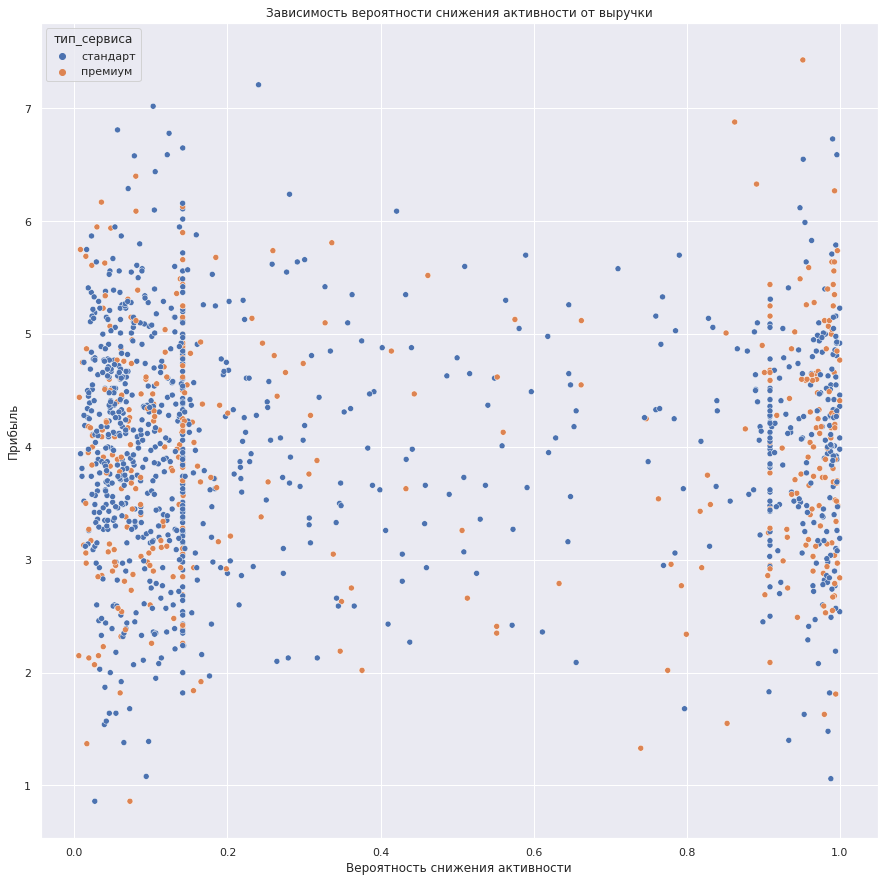

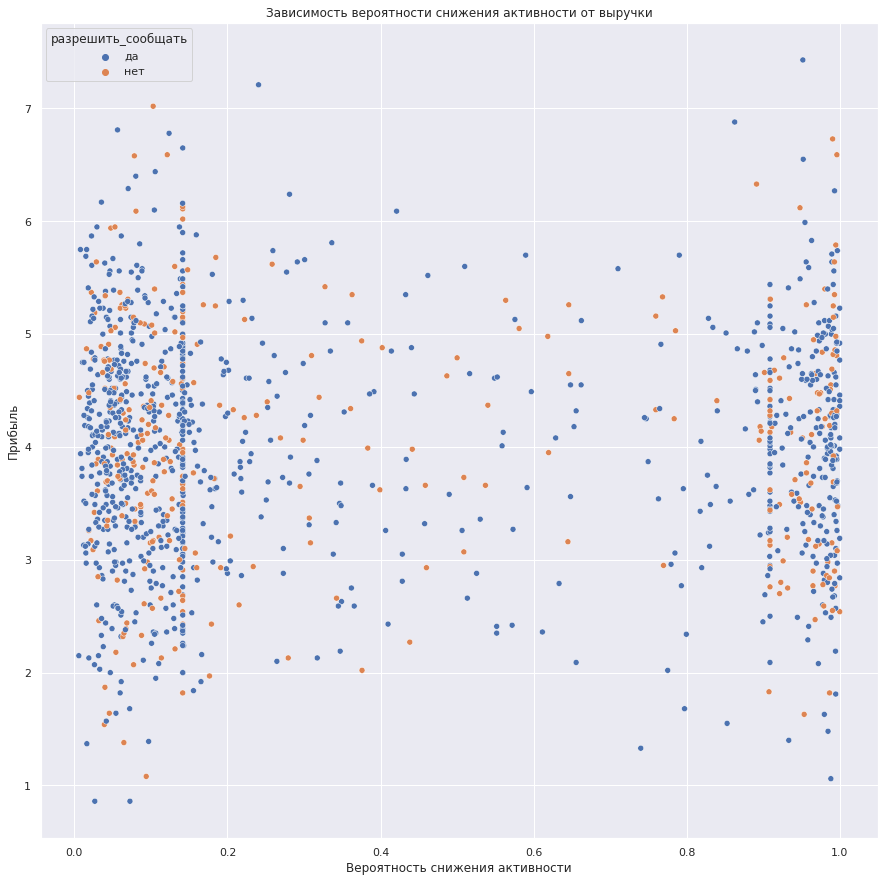

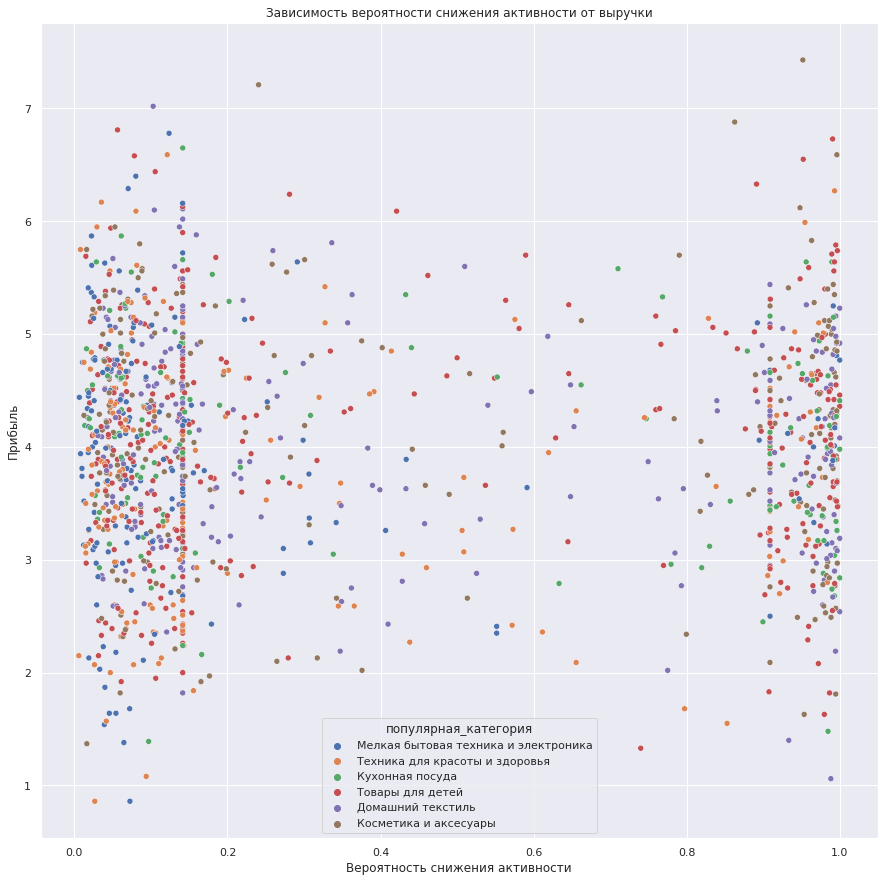

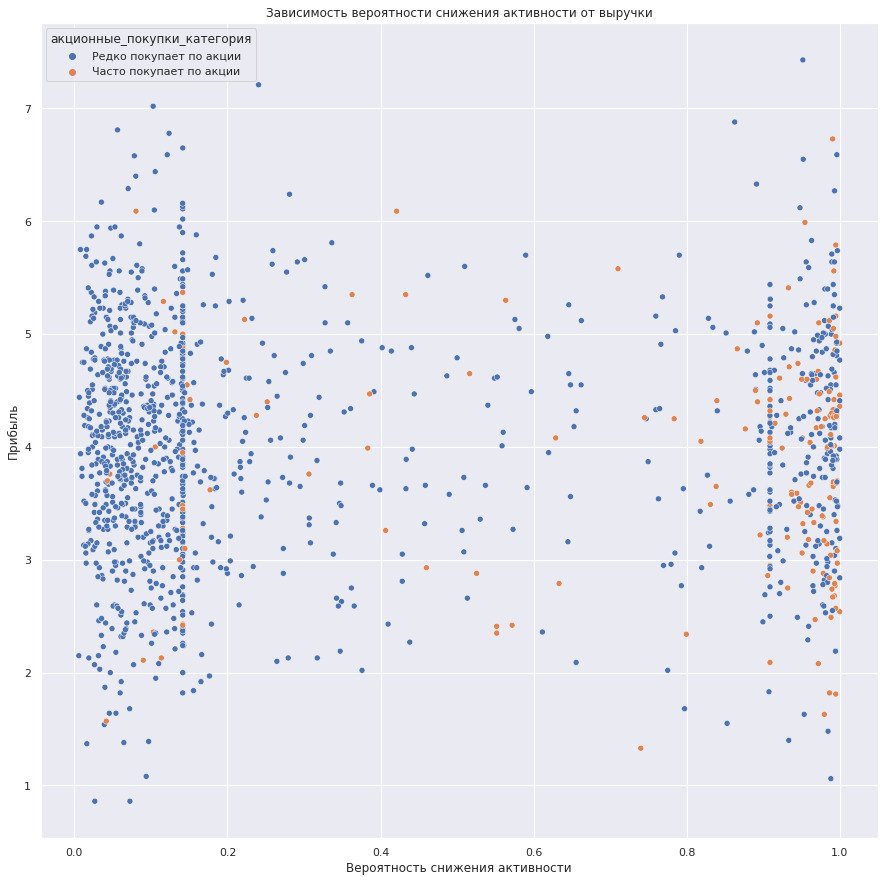

In [57]:
for cat_col in cat_columns:
        fig = plt.figure(figsize=(15,15))
        sns.scatterplot(data=df_full, y='прибыль', x='вероятность_снижения', hue=cat_col)
        plt.xlabel('Вероятность снижения активности')
        plt.ylabel('Прибыль')
        plt.title('Зависимость вероятности снижения активности от выручки')
        plt.show()

При построении диаграммы рассеивания мы видим что снижение активности может быть у тех пользователей, которые часто покупают по акции(Последний график), выделим сегмент пользователей, которые покупают часто по акции, и у которых высокая вероятность снижения активности.

In [58]:
df_full['сегмент'] = df_full\
.apply( lambda row: 'Исследуемый сегмент' \
        if row['вероятность_снижения'] > 0.8 and row['акционные_покупки_категория']=='Часто покупает по акции' \
        else 'Остальные пользователи' \
      , axis=1)

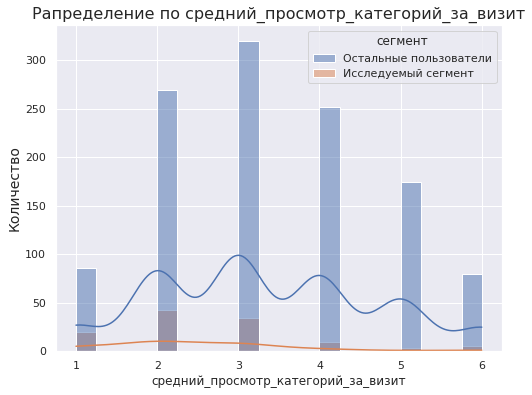

In [59]:
histogram(df_full, 'средний_просмотр_категорий_за_визит', 'сегмент')

Как видно по гистограмме, пользователи из исследуемого сегмента, просматривают не больше 4 категорий товаров, за редким исключением, что может означать, что пользователи, приходят с конкретной целью, а не с целью по искать что либо.

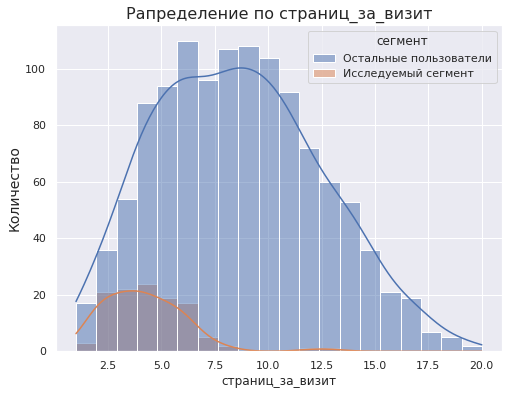

In [60]:
histogram(df_full, 'страниц_за_визит', 'сегмент')

В исследуемом сегменте пользователи, просматривают не больше 6 страниц, это может означать, что пользователь смотрит максимум аналоги того, что ему нужно купить в данный момент.

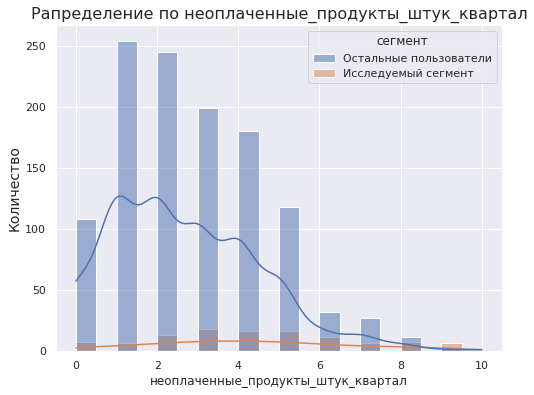

In [61]:
histogram(df_full, 'неоплаченные_продукты_штук_квартал', 'сегмент')

По данной гистограмме видно, что пользователи, достаточно часто оставляют минимум 2 товара в корзине, откладывая покупку на неопределенный срок.

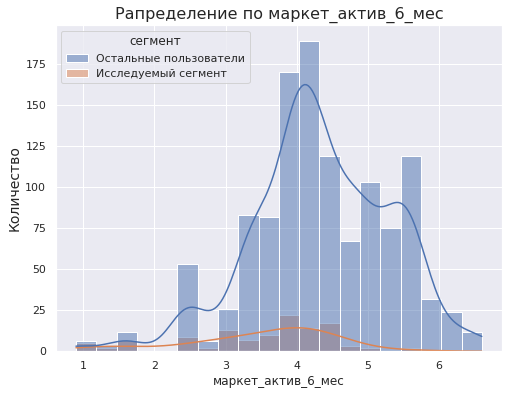

In [62]:
histogram(df_full, 'маркет_актив_6_мес', 'сегмент')

По данной гистограмме видно, что с такими пользователями, рекламная активность за последние 6 месяц составляет до 5 у.е.

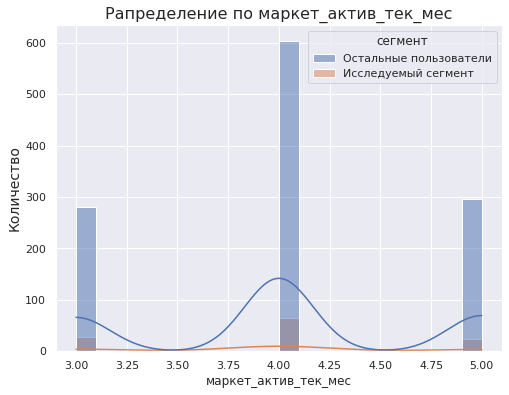

In [63]:
histogram(df_full, 'маркет_актив_тек_мес', 'сегмент')

По данной гистограмме видим, что активность пользователей, за текущий месяц примерно такая же как и у остальных пользователей.

### Вывод по сегментации покупателей.
    Выбрав сегмент пользователей с высоким шансом снижения покупательской активности можно сделал следующие выводы:
        1. Пользователи из данного сегмента, либо заказывают определенные товары, либо ждут акции на какие то другие товары.
        2. Рекламная активность с этими пользователями ниже, чем с другими.
        3. Данные пользователи, оставляют в корзине минимум 2 товара, хотя в других сегментах, есть пользователи которые выкупают все.

## Общий вывод, и рекомендации:
### Выводы:
1. [Выводы по загрузке и исследованию данных](https://k8s.jupyterhub.praktikum-services.ru/user/user-0-870113759/notebooks/877ee7f1-972c-420b-bef9-26589625d782.ipynb#Вывод-по-загрузке-и-исследованию-данных:)
2. [Выводы по предобработке данных.](https://k8s.jupyterhub.praktikum-services.ru/user/user-0-870113759/notebooks/877ee7f1-972c-420b-bef9-26589625d782.ipynb#Вывод-по-предобработке-данных:)
3. Выводы по исследовательскому анализу данных:\
    [Вывод по первому набору данных.](https://k8s.jupyterhub.praktikum-services.ru/user/user-0-870113759/notebooks/877ee7f1-972c-420b-bef9-26589625d782.ipynb#Вывод-по-первому-набору-данных:)\
    [Вывод по второму набору данных.](https://k8s.jupyterhub.praktikum-services.ru/user/user-0-870113759/notebooks/877ee7f1-972c-420b-bef9-26589625d782.ipynb#Вывод-по-второму-набору-данных:)\
    [Вывод по третьему набору данных.](https://k8s.jupyterhub.praktikum-services.ru/user/user-0-870113759/notebooks/877ee7f1-972c-420b-bef9-26589625d782.ipynb#Вывод-по-третьему-набору-данных:)\
    [Вывод по четвертому набору данных.](https://k8s.jupyterhub.praktikum-services.ru/user/user-0-870113759/notebooks/877ee7f1-972c-420b-bef9-26589625d782.ipynb#Вывод-по-четвертому-набору-данных:)\
    [Общий вывод по исследовательскому анализу.](https://k8s.jupyterhub.praktikum-services.ru/user/user-0-870113759/notebooks/877ee7f1-972c-420b-bef9-26589625d782.ipynb#Вывод-по-исследовательскому-анализу:)
4. [Вывод по объеденению таблиц.](https://k8s.jupyterhub.praktikum-services.ru/user/user-0-870113759/notebooks/877ee7f1-972c-420b-bef9-26589625d782.ipynb#Вывод-по-объеденению:)
5. [Вывод по кореляционному анализу.](https://k8s.jupyterhub.praktikum-services.ru/user/user-0-870113759/notebooks/877ee7f1-972c-420b-bef9-26589625d782.ipynb#Вывод-по-кореляционному-анализу:)
6. [Вывод по выбору лучшей модели и метриках.](https://k8s.jupyterhub.praktikum-services.ru/user/user-0-870113759/notebooks/877ee7f1-972c-420b-bef9-26589625d782.ipynb#Вывод-по-выбору-лучшей-модели-и-метрики.)
7. [Вывод по анализу важности признаков](https://k8s.jupyterhub.praktikum-services.ru/user/user-0-870113759/notebooks/877ee7f1-972c-420b-bef9-26589625d782.ipynb#Вывод-по-анализу-важности-признаков.)
8. [Вывод по сегментации покупателей](https://k8s.jupyterhub.praktikum-services.ru/user/user-0-870113759/notebooks/877ee7f1-972c-420b-bef9-26589625d782.ipynb#Вывод-по-сегментации-покупателей.)
### Рекомендации:
    1. Проведя работу над сегментацией пользователей можно выявить несколько проблем:\
        1. Первая из них это малое количество рекламных взаимодействий с пользователями, чья активность снижается, возможно стоит выдавать больше рекламы данным пользователям для стимулирования к покупкам.\
        2. Вторая проблема это присутсвие неоплаченных товаров в корзине, возможно пользователям стоит напоминать о наличии товаров в корзине, а так же предлагать им аналоги данных товаров в виде рекламы.\
        3. Третья проблема в данно сегменте, что пользователи часто ждут акции на товары которые они хотят купить, стоит увеличить кол-во акционных предложений, а так же улучшить информирование пользователей об этих акциях.